In [23]:
### IMPORTS
import os
from dotenv import load_dotenv
import dspy
from dspy.evaluate import Evaluate
from dspy.teleprompt import BootstrapFewShot, BootstrapFewShotWithRandomSearch
from nltk.metrics import edit_distance
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

c:\Users\steph\OneDrive\Documents\GitHub\Lovelytics\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
### SETUP DSPY STUFF
load_dotenv()

openai_api_key = os.getenv("OPENAI_API_KEY")
if not openai_api_key:
    raise ValueError("OpenAI API key not found in .env file")

lm = dspy.LM('gpt-4o-mini')
dspy.configure(lm=lm)

class EnhancedPromptRefiner(dspy.Signature):
    """Refine a prompt for a given subtask with enhanced context."""
    subtask = dspy.InputField(desc="The specific subtask for which a prompt needs to be refined."
                                   "This should be a concise description of the task (e.g., 'Analyze sales data').")

    job_context = dspy.InputField(desc="The broader job context in which the subtask exists"
                                       "This provides additional information about the purpose or environment of the task.")
    
    audience = dspy.InputField(
        desc="The target audience for the refined prompt. "
             "This helps tailor the prompt to the needs and expertise of the audience.")
    
    tone = dspy.InputField(
        desc="The desired tone or style of the refined prompt (e.g., 'Formal', 'Casual', 'Technical').",
        default="Neutral")

    output_format = dspy.InputField(
        desc="The desired structure or format of the LLM's response (e.g., 'Bullet Points', 'Step-by-Step Instructions').",
        default="Freeform"
    )

    refined_prompt = dspy.OutputField(desc="A refined, detailed prompt for an LLM that it can use to execute the given subtask and job context"
                                           "The output includes structured sections such as task requirements, context, "
                                           "and expected output format to guide the LLM effectively."  )

class PromptGenerator(dspy.Module):
    def __init__(self):
        super().__init__()
        self.generate = dspy.ChainOfThought(EnhancedPromptRefiner)

    def forward(self, subtask, job_context, audience, tone, output_format):
        return self.generate(subtask=subtask, job_context=job_context, audience=audience, tone=tone, output_format=output_format)

def comprehensive_prompt_metric(example, pred, trace=None):
    prompt = pred.refined_prompt
    
    # Readability score (using NLTK's edit distance for complexity this will be changed later)
    readability_score = 1 / (1 + edit_distance(prompt, example.subtask + " " + example.job_context + " " + example.audience + " " + example.tone + " " + example.output_format))
    
    # TF-IDF and cosine similarity
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([prompt, example.subtask + " " + example.job_context + " " + example.audience + " " + example.tone + " " + example.output_format])
    relevance_score = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
    
    # Structural completeness
    structural_elements = ["Context:", "Task:", "Requirements:", "Output format:"]
    structure_score = sum(1 for element in structural_elements if element in prompt) / len(structural_elements)
    
    # Combine 
    overall_score = np.mean([readability_score, relevance_score, structure_score])
    
    return overall_score

def load_trainset_from_csv(fp, n=50):
    df = pd.read_csv(fp)
    sample = df.sample(n=n, random_state=42)
    trainset = [
        dspy.Example(subtask=row['Task'], job_context=row['Title'])
        for _, row in sample.iterrows()
    ]
    return trainset

trainset_small = [
    dspy.Example(
        subtask="Gather Historical Financial Data",
        job_context="Investment Research",
        audience="Professors",
        tone="Formal",
        output_format="Numbered list"
    ).with_inputs("subtask", "job_context", "audience", "tone", "output_format"),
    dspy.Example(
        subtask="Implement Machine Learning Model",
        job_context="Predictive Analytics",
        audience="Child",
        tone="Formal",
        output_format="Numbered list"
    ).with_inputs("subtask", "job_context", "audience", "tone", "output_format"),
    dspy.Example(
        subtask="Conduct User Experience Survey",
        job_context="Product Development",
        audience="Students",
        tone="Formal",
        output_format="Numbered list"
    ).with_inputs("subtask", "job_context", "audience", "tone", "output_format"),
    dspy.Example(
        subtask="Perform Environmental Impact Assessment",
        job_context="Sustainability Planning",
        audience="Workers",
        tone="Formal",
        output_format="Numbered list"
    ).with_inputs("subtask", "job_context", "audience", "tone", "output_format"),
]

trainset_large = load_trainset_from_csv(fp='task_statements.csv')

class OptimizerManager:
    def __init__(self, optimizer_type, metric, config=None):
        self.metric = metric
        self.config = config
        self.optimizer = self._initialize_optimizer(optimizer_type)

    def _initialize_optimizer(self, optimizer_type):
        if optimizer_type == 'BootstrapFewShot':
            return BootstrapFewShot(metric=self.metric, **self.config)
        elif optimizer_type == 'BootstrapFewShotWithRandomSearch':
            return BootstrapFewShotWithRandomSearch(metric=self.metric, **self.config)
        else:
            raise ValueError("Invalid optimizer type. Choose 'BootstrapFewShot' or 'BootstrapFewShotWithRandomSearch'")

    def compile(self, module, trainset):
        return self.optimizer.compile(module, trainset=trainset)

# Optimizers
optimizer_type = 'BootstrapFewShot'
# optimizer_type = 'BootstrapFewShotWithRandomSearch'

config = dict(max_bootstrapped_demos=3)
config_random = dict(max_bootstrapped_demos=3, max_labeled_demos=3, num_candidate_programs=10, num_threads=4)

optimizer_manager = OptimizerManager(optimizer_type, metric=comprehensive_prompt_metric, config=config)

compiled_generator = optimizer_manager.compile(PromptGenerator(), trainset=trainset_small)

def get_refined_prompt(subtask, job_context, audience, tone, output_format, compiled_generator):
    print(f"Generating refined prompt for '{subtask}' in '{job_context}' with audience '{audience}'...")
    result = compiled_generator(subtask=subtask, job_context=job_context, audience=audience, tone=tone, output_format=output_format)
    return result.refined_prompt

 75%|███████▌  | 3/4 [00:24<00:08,  8.15s/it]

Bootstrapped 3 full traces after 3 examples for up to 1 rounds, amounting to 3 attempts.


In [4]:
test_cases = [
    {
        'subtask': 'Examine documents to determine degree of risk from factors such as applicant health, financial standing and value, and condition of property.', 
        'context': 'Insurance Underwriters',
        'audience': 'LLM',
        'tone': 'Clear',
        'output_format': 'Bullet Points'
    }
]

In [ ]:

### GET THE REFINED PROMPT - THIS IS WHAT WE WANT TO IMPROVE SO THAT WE CAN COMPLETE THE TASK THE BEST
for elem in test_cases:
    subtask = elem['subtask']
    job_context = elem['context']
    audience = elem['audience']
    tone = elem['tone']
    output_format = elem['output_format']
    refined_prompt = get_refined_prompt(subtask, job_context, audience, tone, output_format, compiled_generator)
    print(f"\nRefined prompt for '{subtask}' in the context of '{job_context}' with audience '{audience}':")
    print(refined_prompt)
    print("-" * 80)

print("\nEvaluating the compiled generator...")
evaluator = Evaluate(devset=trainset_small, metric=comprehensive_prompt_metric, num_threads=4, display_progress=True)
score = evaluator(compiled_generator)
print(f"Overall score: {score}")

Generating refined prompt for 'Examine documents to determine degree of risk from factors such as applicant health, financial standing and value, and condition of property.' in 'Insurance Underwriters' with audience 'LLM'...

Refined prompt for 'Examine documents to determine degree of risk from factors such as applicant health, financial standing and value, and condition of property.' in the context of 'Insurance Underwriters' with audience 'LLM':
- **Objective**: Assess the degree of risk associated with an insurance application by examining relevant documents.
- **Factors to Consider**:
  - **Applicant Health**: Review medical records and health history to identify any pre-existing conditions or health risks.
  - **Financial Standing**: Analyze financial documents such as credit reports, income statements, and debt levels to evaluate the applicant's financial stability.
  - **Property Value**: Examine property appraisals and market analyses to determine the current value of the prop

2024/11/28 14:25:28 INFO dspy.evaluate.evaluate: Average Metric: 0.16422176669083682 / 4 (4.1%)



Overall score: 4.11


In [ ]:
### THE USER CAN EDIT THE PROMPT FURTHER BEFORE SUBMITTING TO AN LLM
refined_prompt_edited = '''
    - **Objective**: Assess the degree of risk associated with an insurance application by examining relevant documents.
    - **Factors to Consider**:
        - **Applicant Health**: Review medical records and health history to identify any pre-existing conditions or health risks.
    - **Documentation Required**: List the specific documents needed for each factor, such as:
        - Medical records for health assessment
    - **Risk Assessment Criteria**: Define the criteria for evaluating risk levels based on the gathered information, including thresholds for acceptable risk.
    - **Final Evaluation**: Summarize the findings and provide a risk rating or recommendation based on the analysis of the documents.
    - **Output Format**: Provide the criteria and evaluation as an output in JSON format. 
'''

In [ ]:
### PDF TO IMAGE FOR LLM INPUT
import base64
import io

import fitz
from PIL import Image


def pdf_page_to_base64(pdf_path: str, page_number: int):
    pdf_document = fitz.open(pdf_path)
    page = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix = page.get_pixmap()
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    buffer = io.BytesIO()
    img.save(buffer, format="PNG")

    return base64.b64encode(buffer.getvalue()).decode("utf-8")

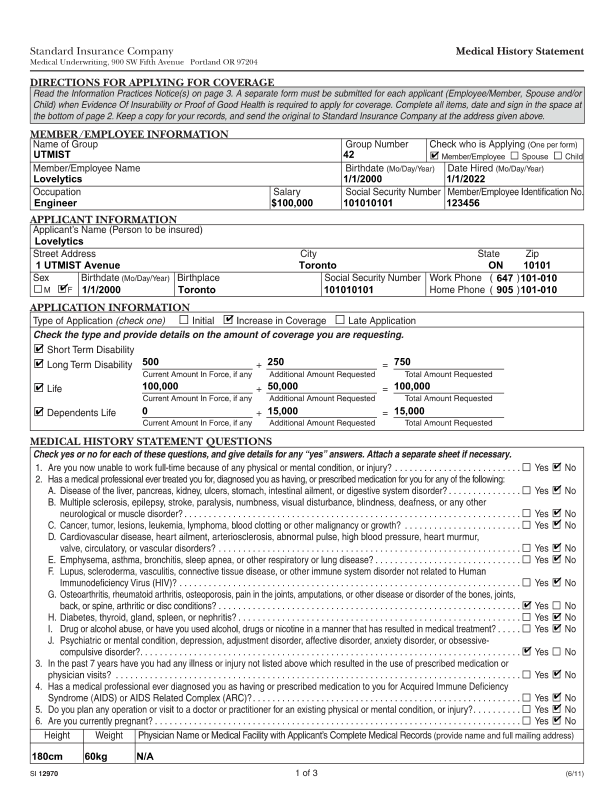

In [ ]:
from IPython.display import Image as IPImage
from IPython.display import display

file_path = 'llm-inputs/insurance-underwriters/insurance_underwriters_health_test.pdf'

pg1 = pdf_page_to_base64(file_path, 1)
pg2 = pdf_page_to_base64(file_path, 2)
pg3 = pdf_page_to_base64(file_path, 3)
display(IPImage(data=base64.b64decode(pg1)))

In [9]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [21]:
from langchain_core.messages import HumanMessage

query = refined_prompt_edited

message = HumanMessage(
    content=[
        {"type": "text", "text": query},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{pg1}"},
        },
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{pg2}"},
        },
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{pg3}"},
        },
    ],
)
response = llm.invoke([message])
print(response.content)

Here's a structured JSON output based on the information provided in the insurance application document:

```json
{
  "insurance_application": {
    "applicant_info": {
      "name": "Lovelytics",
      "social_security_number": "101010101",
      "birthdate": "01/01/2000",
      "address": {
        "street": "1 UTMIST Avenue",
        "city": "Toronto",
        "state": "ON",
        "zip": "10101"
      },
      "occupation": "Engineer",
      "salary": 100000
    },
    "application_information": {
      "type_of_application": {
        "initial": true,
        "increase_coverage": false,
        "late_application": false
      },
      "coverage_requested": {
        "short_term_disability": 750,
        "long_term_disability": 100000,
        "life_insurance": 50000,
        "dependents_life": 15000
      }
    },
    "medical_history": {
      "questions": [
        {
          "question": "Have you now or have you ever been unable to work full-time because of any physical or me